# Generate multiple plots about Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and makes all
kind of plots about the data.
</i>

### Notebook configuration

In [2]:
run_number             = 4841
correction_filename    = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename           = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename_mc = f"$IC_DATA/MC/Kr/paola/corrections_MC_{run_number}.h5"
dst_filename_mc        =  "$IC_DATA/MC/Kr/paola/dst_MC.h5"
plots_output_folder    = "/Users/Gonzalo/github/papers/KrRunII/imgKr/"

XY_pitch            = 5.0

Zrange              =     0, 600
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5
Erange              =    35, 50
Qrange              =   200, 1500
QErange             =     0, Qrange[1] / Erange[1]

S1Erange            =     0, 40
S1Wrange            =     0, 500
S1Hrange            =     0, 10

S2Erange            =     0, 18e3
S2Wrange            =     0, 50
S2Hrange            =     0, 10e3
NSirange            =     0, 80

Zrange_DV           =   500, 600
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520

XYnbins             =  80
Znbins              = 100
Rnbins              = 100
Phinbins            = 100
Enbins              = 200
Qnbins              = 200

S1Enbins            = 40
S1Wnbins            = 20
S1Hnbins            = 50

S2Enbins            = 100
S2Wnbins            = 50
S2Hnbins            = 80
NSinbins            = 80

DVnbins             = 50

R_fiducial          = 100
Z_fiducial          = 200

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
axis_font_size      = 40
label_font_size     = 30
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = True
with_titles         = False
plots_format        = "png"

### Imports

In [3]:
import os
import time
import collections
import itertools
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import pdf
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer
from invisible_cities.icaro. hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels
from icaro.core.fit_functions import expo_seed

Running on  Mon May 28 13:13:32 2018


### Initialization

In [4]:
save_   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None
def save(*args):
    save_(*args, bbox_inches="tight")

labels = conditional_labels(with_titles)
def labels(x, y, t="", **kwargs):
    plt.xlabel(x, **kwargs)
    plt.ylabel(y, **kwargs)
valuepm = lambda *args: measurement_string(*args).replace("+-", "\pm")

In [5]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] =    figure_size
plt.rcParams[  "font.size"            ] = axis_font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [6]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
Qbins     = np.linspace(*  Qrange   ,   Qnbins + 1)

S1Ebins   = np.linspace(*S1Erange   , S1Enbins + 1)
S1Wbins   = np.linspace(*S1Wrange   , S1Wnbins + 1)
S1Hbins   = np.linspace(*S1Hrange   , S1Hnbins + 1)

S2Ebins   = np.linspace(*S2Erange   , S2Enbins + 1)
S2Wbins   = np.linspace(*S2Wrange   , S2Wnbins + 1)
S2Hbins   = np.linspace(*S2Hrange   , S2Hnbins + 1)
NSibins   = np.linspace(*NSirange   , NSinbins + 1)

XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Phibins   = np.linspace(*Phirange   , Phinbins + 1)
DVbins    = np.linspace(*  Zrange_DV,  DVnbins + 1)

dst_filename           = os.path.expandvars(       dst_filename   )
dst_filename_mc        = os.path.expandvars(       dst_filename_mc)
correction_filename    = os.path.expandvars(correction_filename   )
correction_filename_mc = os.path.expandvars(correction_filename_mc)

In [7]:
Erange              =  35, 50
Erange              =  33.5, 49.5
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)

### Read data

In [8]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R < max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

772665


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,6,8,1.510471e+09,0,1,200.0,3.353130,16.994588,823725.0,14.7000,...,1002500.0,41,178.775,178.775,-180.623891,-61.067526,190.667860,-2.815565,18.316797,15.352102
1,12,21,1.510471e+09,0,1,125.0,1.271123,5.763685,883425.0,6.3500,...,1002500.0,36,119.075,119.075,-168.270263,23.257575,169.869939,3.004247,11.466820,13.968665
2,14,27,1.510471e+09,0,1,150.0,1.976865,8.930014,859950.0,6.8375,...,1003500.0,36,143.550,143.550,5.004905,-31.789076,32.180653,-1.414637,22.182517,29.385406
3,17,29,1.510471e+09,0,1,275.0,3.722116,22.847745,613025.0,10.3750,...,1004500.0,35,391.475,391.475,-30.362521,-136.884955,140.211888,-1.789073,14.704709,36.006950
4,18,32,1.510471e+09,0,1,150.0,2.090557,10.226970,449425.0,11.4625,...,1003500.0,28,554.075,554.075,117.304421,41.295697,124.361014,0.338490,23.385198,15.873189


In [9]:
dst_mc = dstf.load_dst(dst_filename_mc, "DST", "Events")
dst_mc = dst_mc[dst_mc.R < max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst_mc))
dst_mc.head()

3108045


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,Zrms,X,Y,R,Xrms,Yrms
0,0,1,0.0,0,1,175.0,1.631263,9.833888,100125.0,8.144594,...,427507.562500,20,327.382563,327.382563,1.658419,176.647429,-86.390831,196.641018,8.652340,9.010243
1,1,3,0.0,0,1,150.0,1.965153,9.807100,100100.0,7.154562,...,293492.218750,21,193.392219,193.392219,1.345410,-24.921252,-70.631607,74.899217,8.262545,8.445559
2,2,4,0.0,0,1,150.0,3.196390,14.845666,100125.0,9.187812,...,408475.531250,19,308.350531,308.350531,1.655377,-17.870117,177.299095,178.197391,8.521611,8.360495
3,3,5,0.0,0,1,175.0,1.354543,6.758821,100125.0,4.319953,...,146520.609375,18,46.395609,46.395609,0.803334,-74.301840,-16.062459,76.018196,7.586097,6.448224
4,4,6,0.0,0,1,150.0,1.562440,8.450720,100150.0,5.388797,...,180489.171875,20,80.339172,80.339172,0.977606,147.243927,1.019415,147.247456,8.081113,8.291674


In [10]:
ELT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Lifetime")

EGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryE_{XY_pitch:.1f}mm",
                                           norm_strategy =  "index",
                                           norm_opts     = {"index": (40, 40)})

In [11]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time .values.min()) / 60
S2e = dst.S2e.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values

E   = S2e * ELT_correction(Z, X, Y).value * EGEO_correction(X, Y).value

In [12]:
t, e, eu = fitf.profileX(T, E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": 41.5})

E = E * ET_correction(T).value

##### Input maps

In [13]:
import tables as tb
with tb.open_file(correction_filename) as file:
    print(file)
#    print(file.root.XYcorrections.Escale[:10])
#    print("--------")
#    print(file.root.XYcorrections.Escale[3600:3610])

/Users/Gonzalo/github/NEXTdata//XYmaps/corrections_run4841.h5 (File) ''
Last modif.: 'Wed Mar 14 02:39:17 2018'
Object Tree: 
/ (RootGroup) ''
/XYcorrections (Group) ''
/XYcorrections/Escale (Table(7200,), shuffle, zlib(4)) 'XY-dependent energy scale'
/XYcorrections/GeometryE_10.0mm (Table(1600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.0mm (Table(40000,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.2mm (Table(32400,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.5mm (Table(25600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.9mm (Table(19600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_3.3mm (Table(14400,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_4.0mm (Table(10000,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_5.0mm (Table(6400,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_6.7mm (Table(3600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrectio

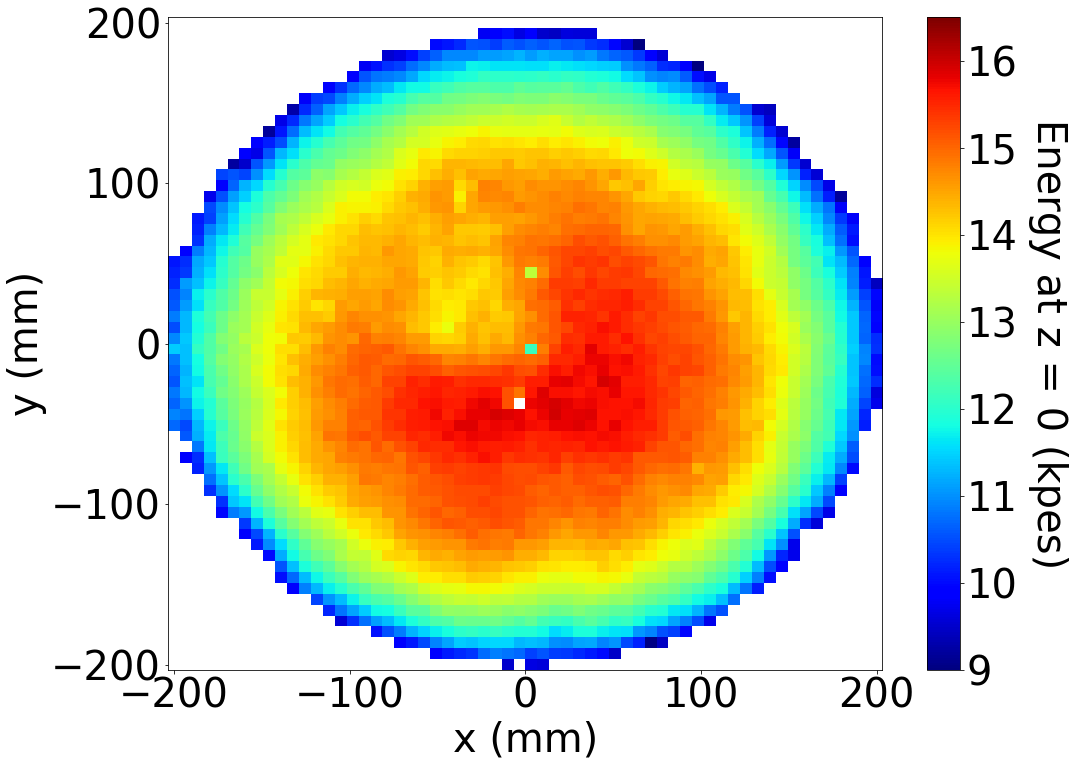

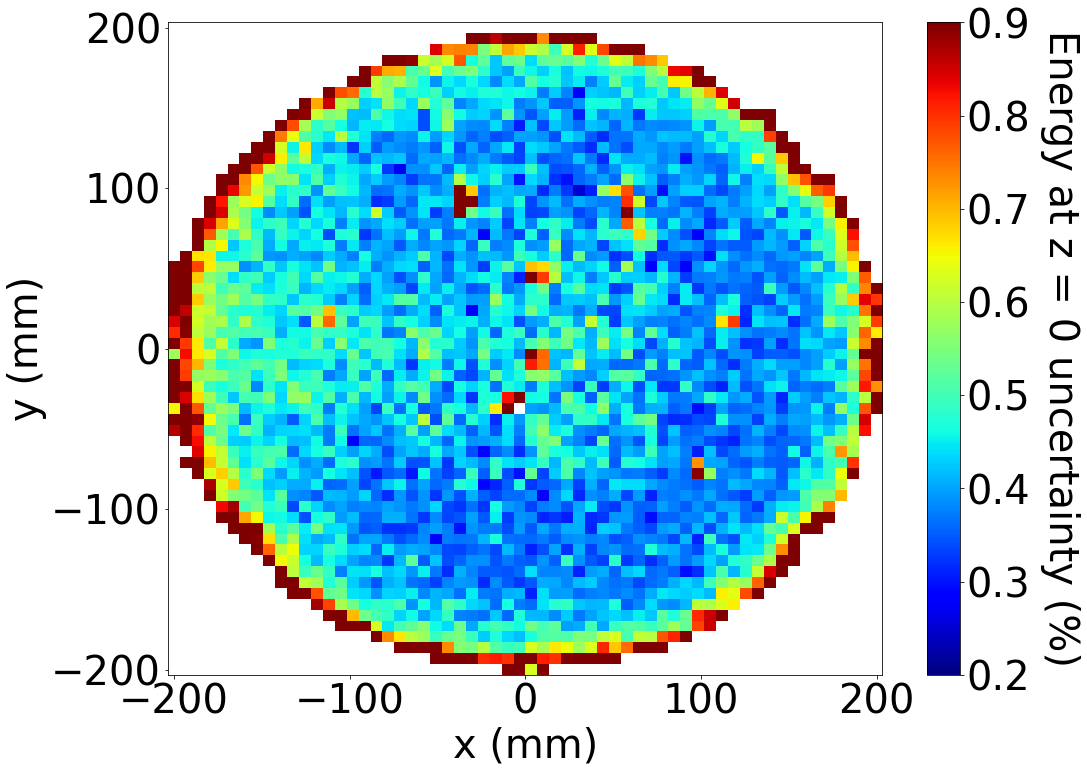

In [14]:
Emap = dstf.load_dst(correction_filename,
                     group = "XYcorrections",
                     node  = "Escale")
Emap = Emap[:3600]

x   = np.unique(Emap.x.values)
y   = np.unique(Emap.y.values)
Es  = Emap.factor     .values.reshape(x.size, y.size)
Eus = Emap.uncertainty.values.reshape(x.size, y.size)
ok  = Es != Es[0,0]

vmin =  9000/1e3
vmax = 16500/1e3

*_, cb = display_matrix(x, y, np.where(ok, Es/1e3, 0),
                        vmin = vmin,
                        vmax = vmax,
                        cmin = vmin,
                        cmap = default_cmap)
cb.set_label("Energy at z = 0 (kpes)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime map")
save(f"energy_z0_map_{run_number}")

vmin = 0.2
vmax = 0.9

*_, cb = display_matrix(x, y, np.where(ok, Eus/Es*100, 0),
                        vmin = vmin,
                        vmax = vmax,
                        cmin = vmin,
                        cmap = default_cmap)

cb.set_label("Energy at z = 0 uncertainty (%)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime map")
save(f"energy_z0_uncertainty_map_{run_number}")

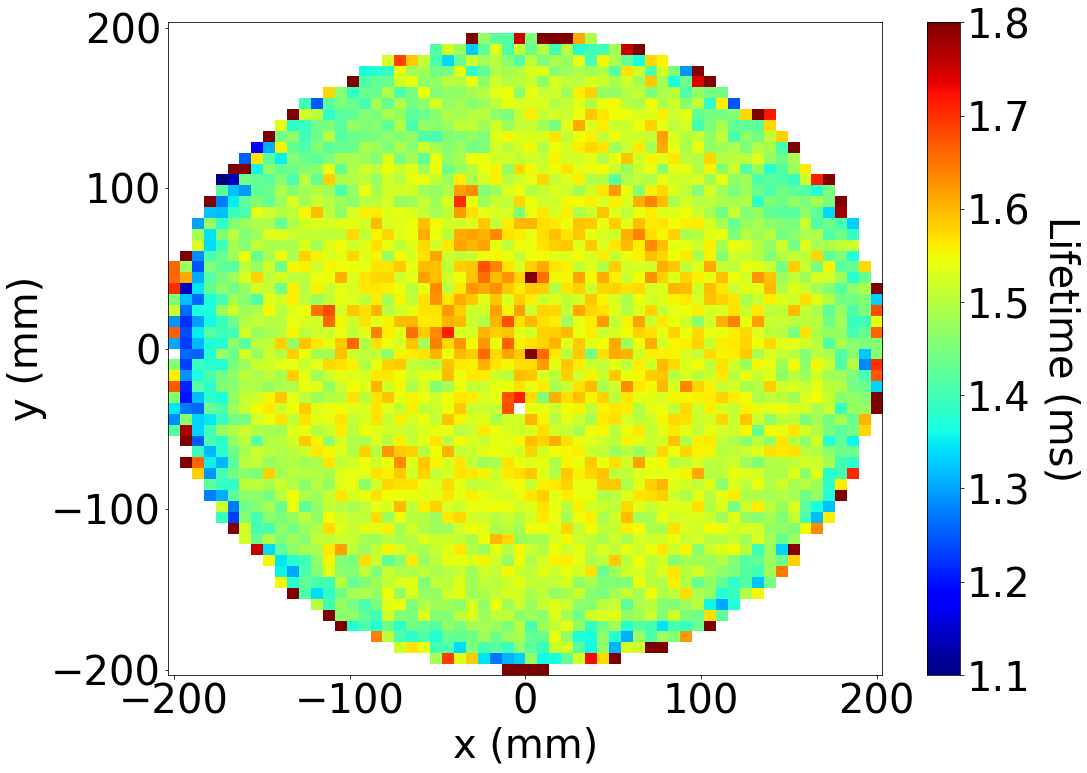

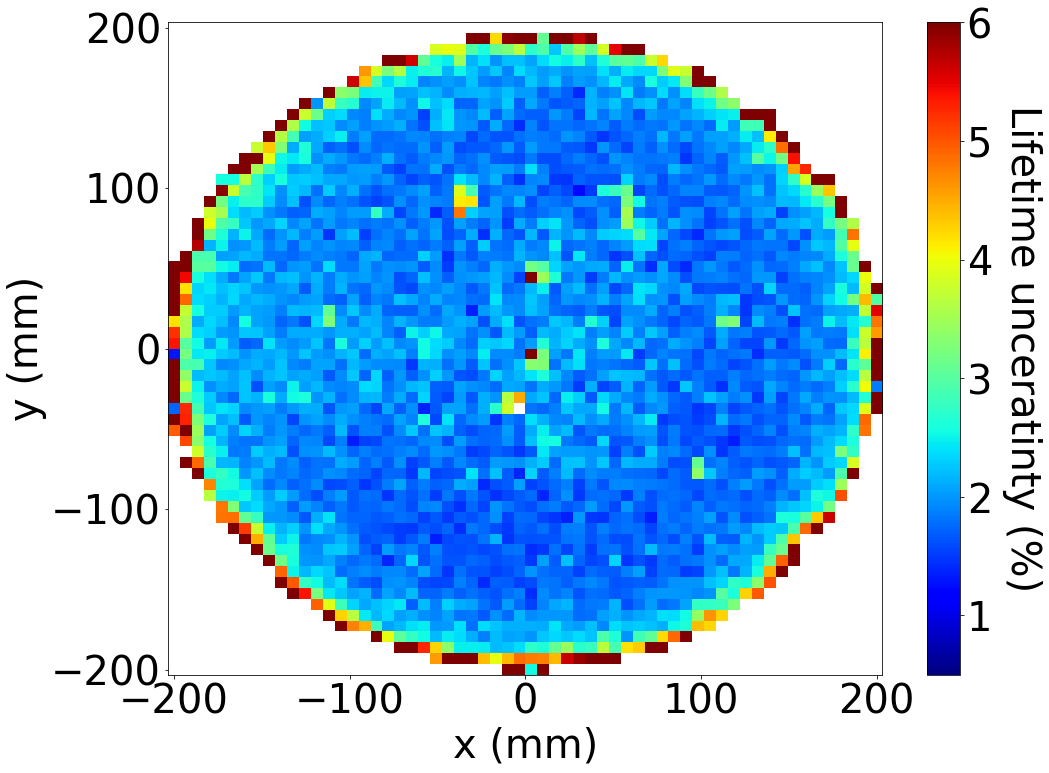

In [15]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)
ok  = LT != LT[0,0]

vmin = 1100
vmax = 1800

*_, cb = display_matrix(x, y, np.where(ok, LT / 1e3, 0),
                        vmin = vmin / 1e3,
                        vmax = vmax / 1e3,
                        cmin = 1,
                        cmap = default_cmap)

cb.set_label("Lifetime (ms)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime map")
save(f"lifetime_map_{run_number}")

vmin = 0.5
vmax = 6

*_, cb = display_matrix(x, y, np.where(ok, LTu/LT*100, 0),
                        vmin = vmin,
                        vmax = vmax,
                        cmin = vmin,
                        cmap = default_cmap)

cb.set_label("Lifetime unceratinty (%)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime uncertainty map")
save(f"lifetime_uncertainty_map_{run_number}")

##### Energy resolution

In [16]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss, n_sigma=3, n_it=10):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    if bkg is fitf.gauss:
        seed         = (      Npeak,     Epeak,  Speak, Npeak*2,   Epeak, Speak*50)
        lower_bounds = (          0,         0,      0,       0,       0,        0)
        upper_bounds = (10 * E.size, np.max(E), np.inf, +np.inf, +np.inf,  +np.inf)
    elif bkg is fitf.polynom:
        seed         = (      Npeak,     Epeak,  Speak,      -1,       1,       1)
        lower_bounds = (          0,         0,      0, -np.inf, -np.inf, -np.inf)
        upper_bounds = (10 * E.size, np.max(E), np.inf,       0, +np.inf, +np.inf)
    else:
        seed         = (      Npeak,     Epeak,  Speak)
        lower_bounds = (          0,         0,      0)
        upper_bounds = (10 * E.size, np.max(E), np.inf)
        bkg          = lambda *args: 0

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])

    for i in itertools.count():
        try:
            seed = np.random.normal(seed, np.abs(seed) * 0.2)
            seed = np.clip(seed, lower_bounds, upper_bounds)
            fit_range = (Epeak - n_sigma * Speak,
                         Epeak + n_sigma * Speak)
            f    = fitf.fit(fun, x, y, seed,
                            fit_range = fit_range,
                            sigma     = yu,
                            bounds    = (lower_bounds, upper_bounds),
                            maxfev    = 10000)

            assert not np.any(np.isclose(f.values, seed)), f.values
            assert f.chi2 < 10

            R   = resolution(f.values, f.errors, 41.5)
            sel = coref.in_range(x, *fit_range)
            ry  = (f.fn(x) - y) / yu
            return reso_fit_data(xy_data(x, y, xu, yu),
                                 xy_data(x[sel], ry[sel], xu, yu[sel]),
                                 f, R)
        except (AssertionError, RuntimeError) as e:
            print(f"Failed {i}")
            if i < n_it: continue
            raise e

Failed 0
Failed 1
Failed 2
Failed 3
Failed 4
Failed 5
Failed 6
Resolution at 41.5 keV: 4.860 +- 0.013
Resolution at 2458 keV: 0.6314 +- 0.0017
Chi2                  : 9.98671982694


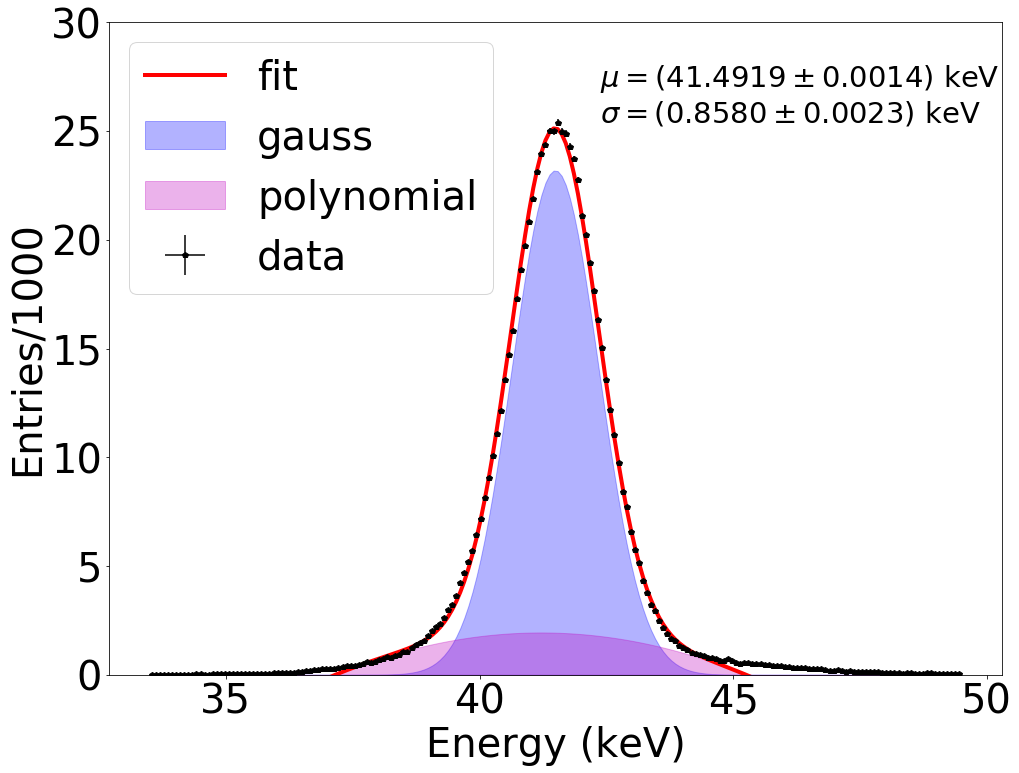

In [17]:
bkg  = fitf.polynom
data = measure_resolution(E, bkg=bkg, n_sigma=2.5)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k", label="data")
plt.plot        (x, data.f.fn   (x)                   , lw=global_linewidth, color=global_linecolor   , label="fit")
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0], label="gauss")
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1], label="polynomial")
plt.text(0.55, 0.85,
         "$\mu = ({})$ keV\n$\sigma = ({})$ keV".format(valuepm(data.f.values[1], data.f.errors[1]),
                                                        valuepm(data.f.values[2], data.f.errors[2])),
         transform=plt.gca().transAxes,
         fontsize = label_font_size - 1)


plt.ylim(0, 28e3)
plt.legend(loc="upper left")

plt.yticks(plt.yticks()[0], list(map(lambda x: str(int(x/1000)), plt.yticks()[0])))
labels("Energy (keV)", "Entries/1000", "Energy spectrum")
save(f"Resolution_{run_number}_full")

In [18]:
1

1

##### Energy resolution best case

In [19]:
Z_fiducial = 150
R_fiducial = 150

Resolution at 41.5 keV: 3.927 +- 0.030
Resolution at 2458 keV: 0.5102 +- 0.0039
Chi2                  : 1.03757466364


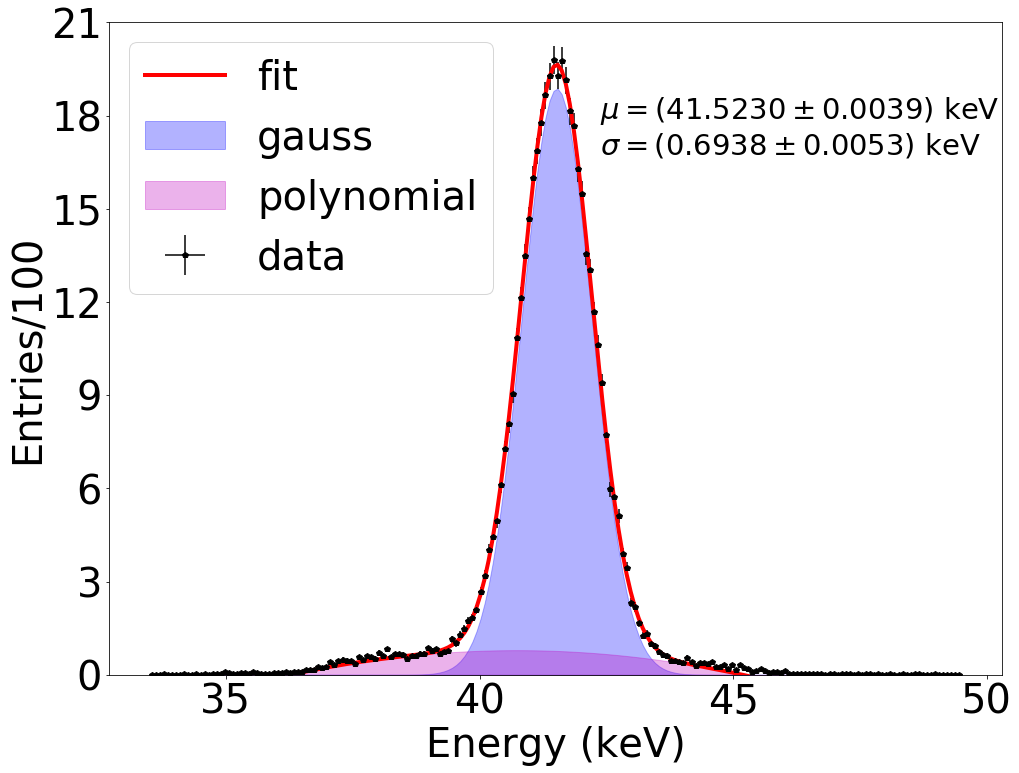

In [20]:
sel_r = coref.in_range(R, 0, R_fiducial)
sel_z = coref.in_range(Z, 0, Z_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_r & sel_z], bkg=bkg, n_sigma=2.6)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k", label="data")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   , label="fit")
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0], label="gauss")
plt.fill_between(x,bkg        (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1], label="polynomial")
plt.text(0.55, 0.8,
         "$\mu = ({})$ keV\n$\sigma = ({})$ keV".format(valuepm(data.f.values[1], data.f.errors[1]),
                                                        valuepm(data.f.values[2], data.f.errors[2])),
         transform=plt.gca().transAxes,
         fontsize = label_font_size - 1)

lims  = 0, 2100
ticks = np.linspace(*lims, 8)
strs  = list(map(lambda x: str(int(x/100)), ticks))
plt.ylim(*lims)
plt.yticks(ticks, strs)

plt.legend(loc="upper left")

labels("Energy (keV)", "Entries/100", f"Energy spectrum for R < {R_fiducial:.0f} mm, Z < {Z_fiducial:.0f} µs")
save(f"Resolution_{run_number}_fid")